### Cab-Driver Agent

Cab drivers, like most people, are incentivised by a healthy growth in income. The goal of your project is to build an RL-based algorithm which can help cab drivers maximise their profits by improving their decision-making process on the field.

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Basic environment parameters

In [2]:
# Defining hyperparameters
m = 5 # number of cities, ranges from 1 ..... m
t = 24 # number of hours, ranges from 0 .... t-1
d = 7  # number of days, ranges from 0 ... d-1
C = 5 # Per kilometer fuel and other costs
R = 9 # per kilometer revenue from a passenger

In [3]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking Q-value convergence

In [4]:
states_track = collections.defaultdict(dict)
def initialise_tracking_states():
    sample_q_values = [((3,0,2),(3,1)),((1,6,3),(2,3)),((2,2,2),(3,2)),((3,10,6),(3,4)),((0,20,3),(1,4)), ((1,23,3),(1,4))]    #select any 4 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        states_track[state][action] = []    #this is an array which will have appended values of that state-action pair for every 2000th episode         

In [5]:
initialise_tracking_states() # initialised all the state-action pairs tracked

In [6]:
# This function will append latest Q-values of the 6 Q-values which are being tracked for checking convergence

def save_tracking_states():
    for state in states_track.keys():
        for action in states_track[state].keys():
            Q = agent.prediction([action], state)
            states_track[state][action].append(Q)          

In [7]:
#Defining a function to save the object as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

## Building Agent Class

In [8]:
class DQNAgent:
    def __init__(self, state_size, action_size):

        # Define size of state and action
        self.state_size = m+t+d 
        self.action_size = m*(m-1) + 1
        self.action_space = [[i,j] for i in range(m) for j in range(m) if i!=j or i==0]

        # These are hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.001        
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.0003
        self.epsilon_min = 0.00000001
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

        

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        model.add(Dense(200, input_dim = 46,activation ='relu'))
        model.add(Dense(150,activation ='relu'))
        model.add(Dense(100,activation ='relu'))
        model.add(Dense(1,activation ='linear'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model
    
    def prediction(self, action, state):
        X_test = np.zeros((len(action), 46))
        for i in range(len(action)):
            dummy = env.state_encod_arch2(state, action[i])
            X_test[i,:] = dummy
        prediction = self.model.predict(X_test)
        prediction = prediction.reshape(len(action))
        return prediction



    def get_action(self, state, episode):
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment
        poss_actions_index, poss_actions = env.requests(state)
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay*episode)
        
    
        if np.random.rand() <= epsilon: # Exploration: randomly choosing and action      
            action_index = np.random.choice(poss_actions_index)
            action = self.action_space[action_index]
        else: #Exploitation: this gets the action corresponding to max q-value of current state
            q_value = self.prediction(poss_actions, state)
            action_index = np.argmax(q_value)
            action = poss_actions[action_index]
        return action, epsilon
        
        
    # save sample <s,a,r,s'> to the replay memory 
    def append_sample(self, state, action, reward, next_state, terminal_state):
        self.memory.append((state, action, reward, next_state, terminal_state))
    

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
  

        if len(self.memory) < self.batch_size:
            return
        
        # Sample batch from the memory
        mini_batch = random.sample(self.memory, self.batch_size)
        update_input = np.zeros((self.batch_size, 46))
        update_output = np.zeros((self.batch_size, self.action_size))

        actions, rewards, terminal_states = [], [], []

        
        
        for i in range(self.batch_size):
            
            state, action, reward, next_state, terminal_state = mini_batch[i]
            
            actions.append(self.action_space.index(action))
            rewards.append(reward)
            terminal_states.append(terminal_state)
            

            update_input[i] = env.state_encod_arch2(state, action)
            update_output[i,:]= self.prediction(self.action_space, next_state)
        
        target = np.zeros((self.batch_size))
        # get your target Q-value on the basis of terminal state
        for i in range(self.batch_size):
            if terminal_states[i]:
                #print(True)
                target[i] = rewards[i]
                
            else:
                target[i] = rewards[i] + self.discount_factor * (np.amax(update_output[i]))

        self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

                
                
    def load(self, name):
        self.model.load_weights(name)
        
                    
    def save(self, name):
        self.model.save_weights(name)

### DQN block

In [9]:
# Importing the environment
from Env import CabDriver

In [10]:
# Initialising the environment
env = CabDriver()
# get size of state and action from environment
state_size = len(env.state_space)
action_size = len(env.action_space)

# agent needs to be initialised outside the loop since the DQN
# network will be initialised along with the agent
agent = DQNAgent(state_size, action_size)

# tracking average reward per episode = total rewards in an episode/ total steps in an episode
avg_reward = []

# tracking total rewards per episode
total_reward  = []

episode: 20000   score: 1377.0   memory length: 2000   epsilon: 0.0024787621518788387


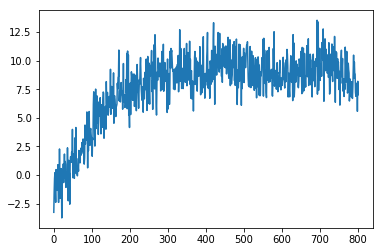

episode: 20025   score: 1260.0   memory length: 2000   epsilon: 0.0024602410516830564
episode: 20050   score: 1503.0   memory length: 2000   epsilon: 0.002441858340132627
episode: 20075   score: 1224.0   memory length: 2000   epsilon: 0.0024236129831951793
episode: 20100   score: 1273.0   memory length: 2000   epsilon: 0.0024055039545645717
episode: 20125   score: 1231.0   memory length: 2000   epsilon: 0.0023875302356031708
episode: 20150   score: 1536.0   memory length: 2000   epsilon: 0.0023696908152845476
episode: 20175   score: 1521.0   memory length: 2000   epsilon: 0.002351984690136601
episode: 20200   score: 1503.0   memory length: 2000   epsilon: 0.002334410864185126
episode: 20225   score: 1494.0   memory length: 2000   epsilon: 0.0023169683488977783
episode: 20250   score: 1163.0   memory length: 2000   epsilon: 0.002299656163128476
episode: 20275   score: 1503.0   memory length: 2000   epsilon: 0.002282473333062201
episode: 20300   score: 1714.0   memory length: 2000   epsi

In [14]:
Episodes = 22000
for episode in range(0,Episodes):
    
    # tracking total rewards, step count
    tot_reward = 0
    step_count = 0
    state = env.reset()
    terminal_state = False
    
    while not terminal_state:
        

        action, epsilon = agent.get_action(state, episode)
        reward = env.reward_func(state, action, Time_matrix)
        
        next_state, terminal_state = env.next_state_func(state, action, Time_matrix)

        # save the sample <s, a, r, s'> to the replay memory
        agent.append_sample(state, action, reward, next_state, terminal_state)
        
        # every time step do the training
        agent.train_model()
        tot_reward += reward
        state = next_state
        step_count += 1
        
        # Store the rewards
        if terminal_state and episode % 25 ==0:
            avg_reward.append(tot_reward/step_count)
            total_reward.append(tot_reward)
            print("episode:", episode, "  score:", tot_reward, "  memory length:",
                      len(agent.memory), "  epsilon:", epsilon)
    
    if episode % 200 == 0:
            agent.save("./cab_driver.h5")

    if episode % 25 == 0:   #every 2000th episode
        save_obj(avg_reward,'Rewards')   
        save_tracking_states()
        save_obj(states_track,'States_tracked')   
        
    
    if episode % 10000 ==0 and episode !=0:
        plt.plot(list(range(len(avg_reward))), avg_reward)
        plt.show()
        

        

### Plotting results

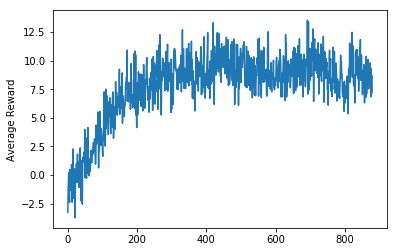

In [15]:
# Plotting average rewards
# x-values = 40000 episodes tracked after every 25th episode
plt.plot(list(range(len(avg_reward))), avg_reward)
plt.ylabel("Average Reward")
plt.show()

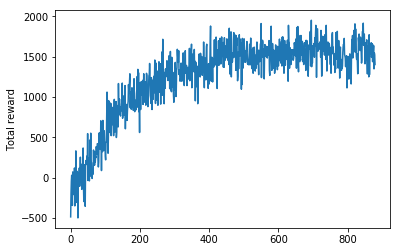

In [16]:
# Plotting total rewards
plt.plot(list(range(len(total_reward))), total_reward)
plt.ylabel("Total reward")
plt.show()

### Intuition behind  total expected reward in an episode

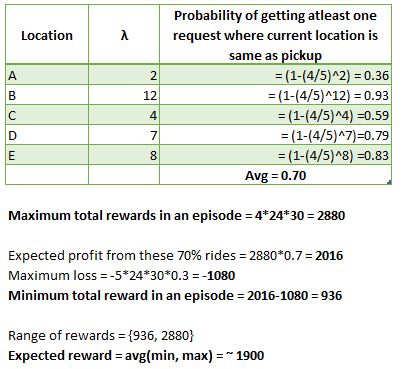 

## Checking Q-values

<function matplotlib.pyplot.show(*args, **kw)>

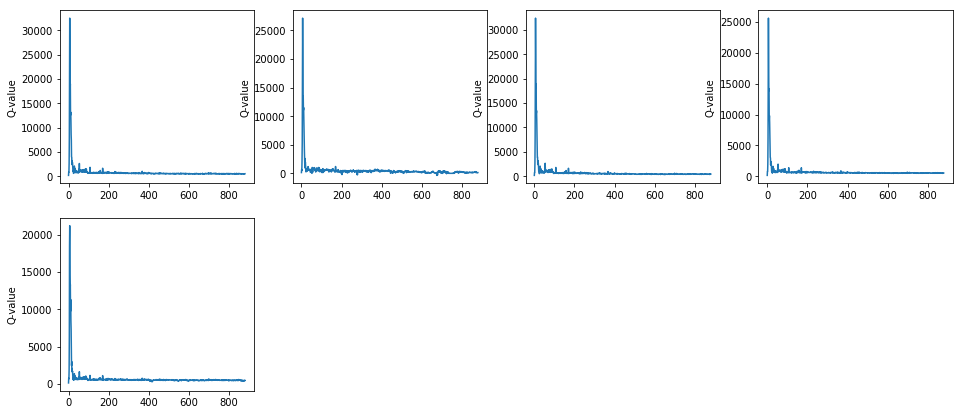

In [17]:
plt.figure(0, figsize=(16,7))

xaxis = np.asarray(range(len(states_track[(3,0,2)][(3,1)])))
plt.subplot(241)
plt.plot(xaxis,np.asarray(states_track[(3,0,2)][(3,1)]))
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(len(states_track[(1,6,3)][(2,3)])))
plt.subplot(242)
plt.plot(xaxis,np.asarray(states_track[(1,6,3)][(2,3)]))
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(len(states_track[(2,2,2)][(3,2)])))
plt.subplot(243)
plt.plot(xaxis,np.asarray(states_track[(2,2,2)][(3,2)]))
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(len(states_track[(3,10,6)][(3,4)])))
plt.subplot(244)
plt.plot(xaxis,np.asarray(states_track[(3,10,6)][(3,4)]))
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(len(states_track[(0,20,3)][(1,4)])))
plt.subplot(245)
plt.plot(xaxis,np.asarray(states_track[(0,20,3)][(1,4)]))
plt.ylabel("Q-value")
plt.show


<function matplotlib.pyplot.show(*args, **kw)>

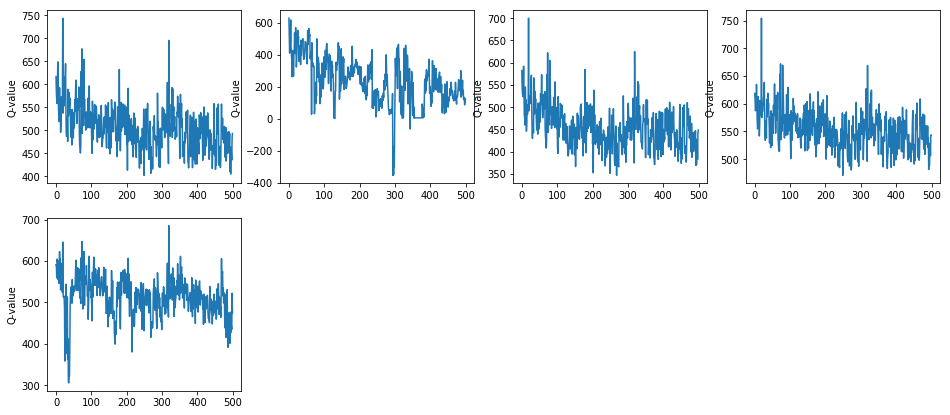

In [18]:
plt.figure(0, figsize=(16,7))

xaxis = np.asarray(range(500))
plt.subplot(241)
plt.plot(xaxis,np.asarray(states_track[(3,0,2)][(3,1)])[-500:])
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(500))
plt.subplot(242)
plt.plot(xaxis,np.asarray(states_track[(1,6,3)][(2,3)])[-500:])
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(500))
plt.subplot(243)
plt.plot(xaxis,np.asarray(states_track[(2,2,2)][(3,2)])[-500:])
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(500))
plt.subplot(244)
plt.plot(xaxis,np.asarray(states_track[(3,10,6)][(3,4)])[-500:])
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(500))
plt.subplot(245)
plt.plot(xaxis,np.asarray(states_track[(0,20,3)][(1,4)])[-500:])
plt.ylabel("Q-value")
plt.show

#### Interpreting Q-values

#### Epsilon-decay sample function

In [21]:
time = np.arange(0,40000)
epsilon = []
for i in range(0,40000):
    epsilon.append(.00000001 + (1 - 0.00000001) * np.exp(-0.0003*i))

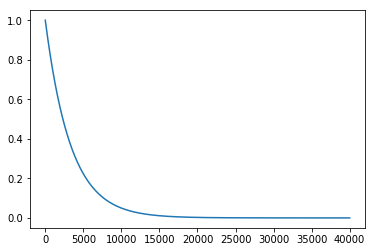

In [22]:
plt.plot(time, epsilon)
plt.show()